In [10]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis.rms import rmsd
from glob import glob
import itertools
import json

In [11]:
 def score_rmsd(rmsd_array, cutoff_well_aligned=5.0, cutoff_well_positioned=15.0):
    
    # Find the largest number of well-aligned structures. Well-aligned means RMSD smaller than rmsd_cutoff
    well_aligned_ubs = (rmsd_array < cutoff_well_aligned).sum(axis=1)

    # Number of well aligned structures
    n = well_aligned_ubs.max()
    
    # Number of similarly well aligned structures
    filtered_well_aligned = rmsd_array[well_aligned_ubs == n]
    
    # Filter for the largest number of well-positioned structures
    well_positioned_ubs = (filtered_well_aligned < cutoff_well_positioned).sum(axis=1)
    m = well_positioned_ubs.max()
    
    filtered_well_positioned = filtered_well_aligned[well_positioned_ubs == m]
    
    combined_rmsds = np.sqrt(np.square(filtered_well_positioned).sum(axis=1) / len(filtered_well_positioned[0]))
    best_id = np.argmin(combined_rmsds)

    # Return ID, no. of well aligned, no. of well positioned
    return filtered_well_positioned[best_id], n, m


def get_af_score(debug_file, rank, af_score_type="iptm+ptm"):
    with open(debug_file, "r") as f:
        json_data=json.load(f)
    model_name=(json_data["order"])[rank]
    af_score=(json_data[af_score_type])[model_name]
    return af_score

def calc_rmsd(input_rec, remove_H=True, debug=False, write=True, ss_dist_cutoff=2.25):

    # Load reference structure
    u_ref = mda.Universe(input_rec["ref_PDB"])
    target_ref = u_ref.select_atoms(input_rec["ref_target"])

    # Load model structure
    model_names = glob(input_rec["model_PDBs"])
        #Remove H atoms in models
    if remove_H:
        new_model_names=[]
        for model_name in model_names:
            u_single_model = mda.Universe(
                        model_name,
                        in_memory = True,
                        )
            all_ha=u_single_model.select_atoms("not type H")
            output_model_name="/".join(model_name.split("/")[:-1])+"/noH_"+model_name.split("/")[-1]
            if debug:
                print(output_model_name)
            if output_model_name==model_name:
                raise Exception("Safeguard to not overwrite original model.")
            all_ha.write(output_model_name)
            new_model_names.append(output_model_name)
        model_names=list(new_model_names)
        #Actual loading
    u_model = mda.Universe(
              *model_names,
              all_coordinates = True,  # To use also the first frame.
              in_memory = True,
    )
    target_model = u_model.select_atoms(input_rec["model_target"])
    
    # Get reference and model ubiquitine atom groups.
    ub_refs = []
    ub_models = []
    for key in list(input_rec.keys()):
        if "ref_Ub" in key:
            ub_refs.append(u_ref.select_atoms(input_rec[key]))
        if "model_Ub" in key:
            ub_models.append(u_model.select_atoms(input_rec[key]))

    # Print summary of atom numbers and frames
    if debug:
        print (" Ref. Target: ", target_ref.n_atoms)
        print (" Mod. Target: ", target_model.n_atoms)
        for i,elem in enumerate(ub_refs):
            print (f" Ref. Ub{i}: ", elem.n_atoms)
        for i,elem in enumerate(ub_models):
            print (f" Mod. Ub{i}: ", elem.n_atoms)
        print (f" Found {u_ref.trajectory.n_frames} reference frames.")

    #
    # RMSD calculation startegy:
    #
    # for all models
    #   for all references
    #     align model target to ref target
    #     align model all to model target
    #     pick as RMSD_A the minimal one, RMSD_B as the second smallest, store the pair
    #   pick the pair with the best combined RMSD = sqrt( RMSD_A^2 / 2 + RMSD_B^2 /2)
    #
    
    if len(ub_models) <= len(ub_refs):
        permuted = list(itertools.permutations(ub_refs))
        permuted = list(set([ elem[:len(ub_models)] for elem in permuted ]))
        fixed = ub_models
    else:
        permuted = list(itertools.permutations(ub_models))
        permuted = list(set([ elem[:len(ub_refs)] for elem in permuted ]))
        fixed = ub_refs
    print (f" Can create {len(permuted)} unique assignments per reference frame.")
    
    # Store results
    all_target_rmsd = np.zeros(len(model_names))
    all_ub_rmsd     = np.zeros((len(model_names), 2))
    all_ub_bond     = np.zeros(len(model_names))
    model_af_scores = np.zeros(len(model_names))
    
    for ts_model in u_model.trajectory:
        #AF score of model
        try:
            model_af_scores[ts_model.frame]=get_af_score(
                         debug_file="/".join(model_names[ts_model.frame].split("/")[:-1]+["ranking_debug_postprocessing.json"]), 
                         rank=int(model_names[ts_model.frame].split("/")[-1].replace("noH_","").replace("ranked_","").replace(".pdb","")), 
                         af_score_type="iptm+ptm")
        except:
            model_af_scores[ts_model.frame]=get_af_score(
                         debug_file="/".join(model_names[ts_model.frame].split("/")[:-1]+["ranking_debug.json"]), 
                         rank=int(model_names[ts_model.frame].split("/")[-1].replace("noH_","").replace("ranked_","").replace(".pdb","")), 
                         af_score_type="iptm+ptm")
        if debug == True:
            print(f'rank :{str(int(model_names[ts_model.frame].split("/")[-1].replace("noH_","").replace("ranked_","").replace(".pdb","")))}, score:{str(model_af_scores[ts_model.frame])}')
        # CYS-CYS Bond formed?
        try:
            if len(u_model.select_atoms(input_rec["mdl_Ub1_CYS"]+" and name SG"))==1 and len(u_model.select_atoms(input_rec["mdl_Ub2_CYS"]+" and name SG"))==1:
                ss_dist = np.linalg.norm(u_model.select_atoms(input_rec["mdl_Ub1_CYS"]+" and name SG").positions-u_model.select_atoms(input_rec["mdl_Ub2_CYS"]+" and name SG").positions)
                if ss_dist_cutoff>=ss_dist:
                    all_ub_bond[ts_model.frame] = 2 # = cys-bond
                else:
                    all_ub_bond[ts_model.frame] = 1 # = cys-no-bond
            else:
                all_ub_bond[ts_model.frame] = 0 # = no-bond 
        except:
            all_ub_bond[ts_model.frame] = 0 # = no-bond
        # Store all best-Ub-RMSD-pair for all reference combinations
        ub_rmsd_for_all_refs = np.zeros((u_ref.trajectory.n_frames, 2))
        ub_well_aligned_for_all_refs = np.zeros(u_ref.trajectory.n_frames)
        ub_well_positioned_for_all_refs = np.zeros(u_ref.trajectory.n_frames)

        for ts_ref in u_ref.trajectory:
            # Align target in model onto target in reference
            #  Step 1: Align target_model onto target_ref
            align.alignto(target_model, target_ref, select="all", match_atoms=False)
            #  Step 2: Align u_model onto target_model
            align.alignto(u_model, target_model, select=input_rec["model_target"], match_atoms=False)
            
            # Compute RMSDs
            #  Step 1: Target vs target
            target_rmsd = rmsd(target_model.positions, target_ref.positions, center=False, superposition=False)
            #  Step 2: Compare all model Ubs vs all ref Ubs. They can differ in their number

            ub_perm_rmsds = np.zeros((len(permuted), len(fixed)))
            for i, perm in enumerate(permuted):
                for j,fp in enumerate(zip(fixed,perm)):
                    f = fp[0]
                    p = fp[1]
                    # print (f.segids[0], "-", p.segids[0], end='   ')
                    ub_perm_rmsds[i,j] = rmsd(f.positions, p.positions, center=False, superposition=False)
            
            ub_rmsd_for_all_refs[ts_ref.frame], n, m = score_rmsd(ub_perm_rmsds)
            ub_well_aligned_for_all_refs[ts_ref.frame] = n
            ub_well_positioned_for_all_refs[ts_ref.frame] = m
            
        # Here, we select the best NMR reference using the same criteria as for the permutation (well aligned, well positioned)
        n_max = ub_well_aligned_for_all_refs.max()
        m_max = ub_well_positioned_for_all_refs.max()
        mask = np.logical_and(ub_well_aligned_for_all_refs == n_max, ub_well_positioned_for_all_refs == m_max)
        # Determine minimal overall diUb RMSD for all the entries, and select the minimal.

        ub_rmsd_for_all_refs = ub_rmsd_for_all_refs[mask]
        combined_rmsds = np.sqrt(np.square(ub_rmsd_for_all_refs).sum(axis=1) / 2)
        best_ref_id = np.argmin(combined_rmsds)
            
        all_target_rmsd[ts_model.frame] = target_rmsd
        all_ub_rmsd[ts_model.frame]     = ub_rmsd_for_all_refs[best_ref_id]

    u_model.select_atoms("not type H").atoms.write(f"{input_rec['aligned_model']}", frames='all') #not type H necessary to ensure same number of atoms for models with and without formed disulfide bond

    return model_names, all_target_rmsd, all_ub_rmsd, all_ub_bond, model_af_scores


In [12]:
#Change paths according to local file structure

input_rec_dic={
  "5ymy":
      {
       "ref_PDB"      : "../04_Ref_structures/5ymy.pdb",
       "ref_target"   : "chainID C and name CA and resnum 19:132",
       "ref_Ub1"      : "chainID A and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",  # DISTAL
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/ADRM1-1-150_and_UBQ_and_UBQ/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 19:132",
       "model_Ub1"    : "chainID B and name CA",
       "model_Ub2"    : "chainID C and name CA and not (resnum 77 and resname CYS)",
       "aligned_model": "5ymy/aligned-5ymy.pdb",
      },
  "5ymy-bond":
      {"ref_PDB"      : "../04_Ref_structures/5ymy.pdb",
       "ref_target"   : "chainID C and name CA and resnum 19:132",
       "ref_Ub1"      : "chainID A and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",   # DISTAL
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/ADRM1-1-150_and_UBQ_K48C_and_UBQ_77C/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 19:132",
       "model_Ub1"    : "chainID B and name CA",
       "model_Ub2"    : "chainID C and name CA and not (resnum 77 and resname CYS)",
       "mdl_Ub1_CYS"  : "chainID B and resname CYS",
       "mdl_Ub2_CYS"  : "chainID C and resname CYS",
       "aligned_model": "5ymy-bond/aligned-5ymy-bond.pdb",
      },
  "6isu":
      {"ref_PDB"      : "../04_Ref_structures/6isu.pdb",
       "ref_target"   : "chainID A and name CA and resnum 4:230",
       "ref_Ub1"      : "chainID C and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",   # DISTAL
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/UCHL3_and_UBQ_and_UBQ/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 4:230",
       "model_Ub1"    : "chainID B and name CA",
       "model_Ub2"    : "chainID C and name CA and not (resnum 77 and resname CYS)",
       "aligned_model": "6isu/aligned-6isu.pdb",
      },
  "6isu-bond":
      {"ref_PDB"      : "../04_Ref_structures/6isu.pdb",
       "ref_target"   : "chainID A and name CA and resnum 4:230",
       "ref_Ub1"      : "chainID C and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",   # DISTAL
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/UCHL3_and_UBQ_K27C_and_UBQ_77C/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 4:230",
       "model_Ub1"    : "chainID B and name CA",
       "model_Ub2"    : "chainID C and name CA and not (resnum 77 and resname CYS)",
       "mdl_Ub1_CYS"  : "chainID B and resname CYS",
       "mdl_Ub2_CYS"  : "chainID C and resname CYS",
       "aligned_model": "6isu-bond/aligned-6isu-bond.pdb",
      },
  "6tuv":
      {"ref_PDB"      : "../04_Ref_structures/6tuv.pdb",
       "ref_target"   : "chainID A and name CA and resnum 110:369",
       "ref_Ub1"      : "chainID H and name CA and resnum 1:71",  # PROXIMAL
       "ref_Ub2"      : "chainID D and name CA and resnum 1:71",  # DISTAL
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/Mindy1-110-384_and_UBQ_and_UBQ/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 1:260",
       "model_Ub1"    : "chainID B and name CA and resnum 1:71",
       "model_Ub2"    : "chainID C and name CA and resnum 1:71",
       "aligned_model": "6tuv/aligned-6tuv.pdb",
      },
  "6tuv-bond":
      {"ref_PDB"      : "../04_Ref_structures/6tuv.pdb",
       "ref_target"   : "chainID A and name CA and resnum 110:369",
       "ref_Ub1"      : "chainID H and name CA and resnum 1:71",  # PROXIMAL
       "ref_Ub2"      : "chainID D and name CA and resnum 1:71",  # DISTAL
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/Mindy1-110-384_and_UBQ_K48C_and_UBQ_77C/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 1:260",
       "model_Ub1"    : "chainID B and name CA and resnum 1:71",
       "model_Ub2"    : "chainID C and name CA and resnum 1:71",
       "mdl_Ub1_CYS"  : "chainID B and resname CYS",
       "mdl_Ub2_CYS"  : "chainID C and resname CYS",
       "aligned_model": "6tuv-bond/aligned-6tuv-bond.pdb",
      },
  "6ud0":
      {"ref_PDB"      : "../04_Ref_structures/6ud0.pdb",
       "ref_target"   : "chainID C and name CA and resnum 3:143",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:76",  # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:76",  # DISTAL
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/Tsg101-1-145_and_UBQ_and_UBQ/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 3:143",
       "model_Ub1"    : "chainID B and name CA and resnum 1:76",
       "model_Ub2"    : "chainID C and name CA and resnum 1:76",
       "aligned_model": "6ud0/aligned-6ud0.pdb",
      },
  "6ud0-bond":
      {"ref_PDB"      : "../04_Ref_structures/6ud0.pdb",
       "ref_target"   : "chainID C and name CA and resnum 3:143",
       "ref_Ub1"      : "chainID A and name CA and resnum 1:76",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:76",  # DISTAL
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/Tsg101-1-145_and_UBQ_K63C_and_UBQ_77C/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 3:143",
       "model_Ub1"    : "chainID B and name CA and resnum 1:76",
       "model_Ub2"    : "chainID C and name CA and resnum 1:76",
       "mdl_Ub1_CYS"  : "chainID B and resname CYS",
       "mdl_Ub2_CYS"  : "chainID C and resname CYS",
       "aligned_model": "6ud0-bond/aligned-6ud0-bond.pdb",
      },
  "7keo":  # has two target chains!
      {"ref_PDB"      : "../04_Ref_structures/7keo.pdb",
       "ref_target"   : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "ref_Ub1"      : "chainID G and name CA and resnum 1:72",  # PROXIMAL
       "ref_Ub2"      : "chainID H and name CA and resnum 1:72",
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/7KEO-chain-1_and_7KEO-chain-2_and_UBQ_and_UBQ/ranked_*.pdb",
       "model_target" : "(chainID A and resnum 5:229) or (chainID B and resnum 2:215) and name CA",
       "model_Ub1"    : "chainID C and name CA and resnum 1:72", 
       "model_Ub2"    : "chainID D and name CA and resnum 1:72",
       "aligned_model": "7keo/aligned-7keo.pdb",
      },
  "7keo-bond":  # has two target chains!
      {"ref_PDB"      : "../04_Ref_structures/7keo.pdb",
       "ref_target"   : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "ref_Ub1"      : "chainID G and name CA and resnum 1:72",  # PROXIMAL
       "ref_Ub2"      : "chainID H and name CA and resnum 1:72",
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/7KEO-chain-1_and_7KEO-chain-2_and_UBQ_K29C_and_UBQ_77C/ranked_*.pdb",
       "model_target" : "(chainID A and resnum 5:229) or (chainID B and resnum 2:215) and name CA",
       "model_Ub1"    : "chainID C and name CA and resnum 1:72",
       "model_Ub2"    : "chainID D and name CA and resnum 1:72",
       "mdl_Ub1_CYS"  : "chainID C and resname CYS",
       "mdl_Ub2_CYS"  : "chainID D and resname CYS",
       "aligned_model": "7keo-bond/aligned-7keo-bond.pdb",
      },
  "7m4n":
      {"ref_PDB"      : "../04_Ref_structures/7m4n.pdb",
       "ref_target"   : "chainID A and name CA and resnum 652:760",
       "ref_Ub1"      : "chainID E and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA",
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/RNF216-649-784_and_UBQ_and_UBQ/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 4:112",
       "model_Ub1"    : "chainID B and name CA",
       "model_Ub2"    : "chainID C and name CA and not (resnum 77 and resname CYS)",
       "aligned_model": "7m4n/aligned-7m4n.pdb",
      },
  "7m4n-bond":
      {"ref_PDB"      : "../04_Ref_structures/7m4n.pdb",
       "ref_target"   : "chainID A and name CA and resnum 652:760",
       "ref_Ub1"      : "chainID E and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA",
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/RNF216-649-784_and_UBQ_K63C_and_UBQ_77C/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 4:112",
       "model_Ub1"    : "chainID B and name CA",
       "model_Ub2"    : "chainID C and name CA and not (resnum 77 and resname CYS)",
       "mdl_Ub1_CYS"  : "chainID B and resname CYS",
       "mdl_Ub2_CYS"  : "chainID C and resname CYS",
       "aligned_model": "7m4n-bond/aligned-7m4n-bond.pdb",
      },
  "7uyh":
      {"ref_PDB"      : "../04_Ref_structures/7uyh.pdb",
       "ref_target"   : "chainID A and name CA and resnum 1:276",
       "ref_Ub1"      : "chainID C and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:75",
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/LotA-1-276_and_UBQ_and_UBQ/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 1:276",
       "model_Ub1"    : "chainID B and name CA and resnum 1:75",
       "model_Ub2"    : "chainID C and name CA and resnum 1:75",
       "aligned_model": "7uyh/aligned-7uyh.pdb",
      },
  "7uyh-bond":
      {"ref_PDB"      : "../04_Ref_structures/7uyh.pdb",
       "ref_target"   : "chainID A and name CA and resnum 1:276",
       "ref_Ub1"      : "chainID C and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:75",
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/LotA-1-276_and_UBQ_K6C_and_UBQ_77C/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 1:276",
       "model_Ub1"    : "chainID B and name CA and resnum 1:75",
       "model_Ub2"    : "chainID C and name CA and resnum 1:75",
       "mdl_Ub1_CYS"  : "chainID B and resname CYS",
       "mdl_Ub2_CYS"  : "chainID C and resname CYS",
       "aligned_model": "7uyh-bond/aligned-7uyh-bond.pdb",
      },
  "9avt":
      {"ref_PDB"      : "../04_Ref_structures/9avt.pdb",
       "ref_target"   : "chainID C and name CA and resnum 664:693 and not altLoc B",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:73    and not altLoc B",   # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/TAB2-664-693_and_UBQ_and_UBQ/ranked_*.pdb", 
       "model_target" : "chainID B and name CA and resnum 1:30    and not altLoc B", #Unrelaxed, hence different chain numberings
       "model_Ub1"    : "chainID C and name CA and resnum 1:73    and not altLoc B",
       "model_Ub2"    : "chainID D and name CA and resnum 1:73    and not altLoc B",
       "aligned_model": "9avt/aligned-9avt.pdb",
      },
  "9avt-bond":
      {"ref_PDB"      : "../04_Ref_structures/9avt.pdb",
       "ref_target"   : "chainID C and name CA and resnum 664:693 and not altLoc B",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:73    and not altLoc B",  # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_PDBs"   : "../03_AF2.3/alphapulldown_output/TAB2-664-693_and_UBQ_K6C_and_UBQ_77C/ranked_*.pdb",
       "model_target" : "chainID A and name CA and resnum 1:30    and not altLoc B",
       "model_Ub1"    : "chainID B and name CA and resnum 1:73    and not altLoc B",
       "model_Ub2"    : "chainID C and name CA and resnum 1:73    and not altLoc B",
       "mdl_Ub1_CYS"  : "chainID B and resname CYS",
       "mdl_Ub2_CYS"  : "chainID C and resname CYS",
       "aligned_model": "9avt-bond/aligned-9avt-bond.pdb",
    },
}

In [13]:
# Compute RMSDs

result_target_dict = {}
result_diub_dict = {}
result_monoub_dict = {}
result_ub_bond_dict = {}
result_ub_bond_dict_dup = {}
result_af_score_dic = {}
for system in input_rec_dic.keys():
    print (system)
    model_names, target_rmsd, ub_rmsd, ub_bond, af_scores = calc_rmsd(input_rec=input_rec_dic[system], debug = False)
    result_target_dict[system] = target_rmsd
    # USE IF THE UB RMSD-S ARE COMBINED
    result_diub_dict[system] = np.sqrt(ub_rmsd[:,0]**2 + ub_rmsd[:,1]**2) / np.sqrt(2)
    result_monoub_dict[system+"-proximal"] = ub_rmsd[:,0]
    result_monoub_dict[system+"-distal"]   = ub_rmsd[:,1]
    result_ub_bond_dict[system] = ub_bond
    result_ub_bond_dict_dup[system] = np.append(ub_bond, ub_bond)
    result_af_score_dic[system] = af_scores
    print ()


5ymy


/home/tb/jastuke/conda-envs/LC3-LIR-analysis/lib/python3.10/site-packages/MDAnalysis/core/universe.py:641: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,
/home/tb/jastuke/conda-envs/LC3-LIR-analysis/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/tb/jastuke/conda-envs/LC3-LIR-analysis/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/home/tb/jastuke/conda-envs/LC3-LIR-analysis/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/tb/jastuke/conda-envs/LC3-LIR-analysis/lib/pyth

 Can create 2 unique assignments per reference frame.

5ymy-bond
 Can create 2 unique assignments per reference frame.

6isu
 Can create 2 unique assignments per reference frame.

6isu-bond
 Can create 2 unique assignments per reference frame.

6tuv
 Can create 2 unique assignments per reference frame.

6tuv-bond
 Can create 2 unique assignments per reference frame.

6ud0
 Can create 2 unique assignments per reference frame.

6ud0-bond
 Can create 2 unique assignments per reference frame.

7keo
 Can create 2 unique assignments per reference frame.

7keo-bond
 Can create 2 unique assignments per reference frame.

7m4n
 Can create 2 unique assignments per reference frame.

7m4n-bond
 Can create 2 unique assignments per reference frame.

7uyh
 Can create 2 unique assignments per reference frame.

7uyh-bond
 Can create 2 unique assignments per reference frame.

9avt
 Can create 2 unique assignments per reference frame.

9avt-bond
 Can create 2 unique assignments per reference frame.



In [14]:
# Transfrom the AF2 model data to pandas DataFrame suitable for seaborn plotting

import pandas as pd

ub_bond_df = pd.DataFrame (result_ub_bond_dict)
ub_bond_df = ub_bond_df.melt(var_name='PDB', value_name='bond')

ub_bond_dup_df = pd.DataFrame (result_ub_bond_dict_dup)
ub_bond_dup_df = ub_bond_dup_df.melt(var_name='PDB', value_name='bond')

target_rmsd_df = pd.DataFrame (result_target_dict)
target_rmsd_df = target_rmsd_df.melt(var_name='PDB', value_name='RMSD')
target_rmsd_df['bond'] = ub_bond_df['bond'].apply(lambda x: 'Cys (bond)' if x==2 else 'Cys (no bond)' if x==1 else "Unmod. (no bond)")
target_rmsd_df['PDB']  = target_rmsd_df['PDB'].str.replace('-bond', '', regex=True)

diub_rmsd_df = pd.DataFrame (result_diub_dict)
diub_rmsd_df = diub_rmsd_df.melt(var_name='PDB', value_name='RMSD')
diub_rmsd_df['bond'] = ub_bond_df['bond'].apply(lambda x: 'Cys (bond)' if x==2 else 'Cys (no bond)' if x==1 else "Unmod. (no bond)")
diub_rmsd_df['PDB']  = diub_rmsd_df['PDB'].str.replace('-bond', '', regex=True)

monoub_rmsd_df = pd.DataFrame (result_monoub_dict)
monoub_rmsd_df = monoub_rmsd_df.melt(var_name='PDB', value_name='RMSD')
monoub_rmsd_df['bond'] = ub_bond_dup_df['bond'].apply(lambda x: 'Cys (bond)' if x==2 else 'Cys (no bond)' if x==1 else "Unmod. (no bond)")
monoub_rmsd_df['PDB']  = monoub_rmsd_df['PDB'].str.replace('-bond', '', regex=True)
monoub_rmsd_df['proximal'] = monoub_rmsd_df['PDB'].apply(lambda x: 'yes' if 'proximal' in x else 'no')
monoub_rmsd_df['PDB']  = monoub_rmsd_df['PDB'].str.replace('-proximal', '', regex=True)
monoub_rmsd_df['PDB']  = monoub_rmsd_df['PDB'].str.replace('-distal', '', regex=True)
    
af_scores_df = pd.DataFrame (result_af_score_dic)
af_scores_df = af_scores_df.melt(var_name='PDB', value_name='iptm+ptm')
af_scores_df['bond'] = ub_bond_df['bond'].apply(lambda x: 'Cys (bond)' if x==2 else 'Cys (no bond)' if x==1 else "Unmod. (no bond)")
af_scores_df['PDB']  = af_scores_df['PDB'].str.replace('-bond', '', regex=True)

(-0.5, 7.5)


/tmp/ipykernel_1284655/3807957203.py:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_facecolor(colors[0])
/tmp/ipykernel_1284655/3807957203.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_facecolor(colors[1])
/tmp/ipykernel_1284655/3807957203.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_facecolor(colors[2])
/tmp/ipykernel_1284655/3807957203.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_linew

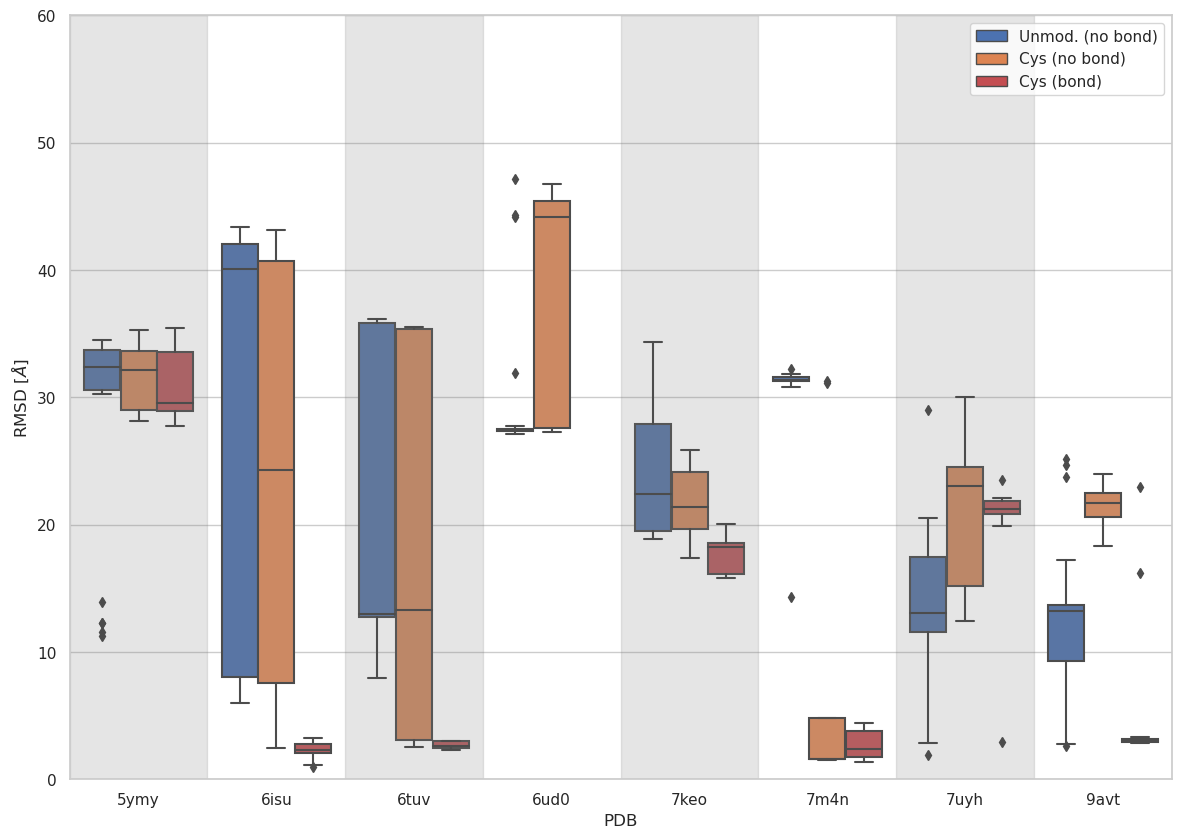

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn
plt.rcParams['svg.fonttype'] = 'none'
# Get the default color palette
colors = seaborn.color_palette()
colors = [i for index, i in enumerate(colors) if index not in [2]]  #Slightly more color-blind friendly

fig = plt.figure(layout="constrained")
 
# use to set style of background of plot
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")


ax = seaborn.boxplot(x="PDB", y="RMSD", hue="bond", hue_order=["Unmod. (no bond)", "Cys (no bond)", "Cys (bond)"], data=diub_rmsd_df, palette=colors)
ax.set_ylabel(r'RMSD [$\AA$]')
ax.set_ylim([0,60])
ax.legend(title=None)
leg = ax.get_legend()
leg.legendHandles[0].set_facecolor(colors[0])
leg.legendHandles[1].set_facecolor(colors[1])
leg.legendHandles[2].set_facecolor(colors[2])
leg.legendHandles[0].set_linewidth(1)
leg.legendHandles[1].set_linewidth(1)
leg.legendHandles[2].set_linewidth(1)



limits = ax.get_xlim()
print (limits)
ax.axvspan(-0.5, 0.5, color='gray', alpha=0.2)
ax.axvspan( 1.5, 2.5, color='gray', alpha=0.2)
ax.axvspan( 3.5, 4.5, color='gray', alpha=0.2)
ax.axvspan( 5.5, 6.5, color='gray', alpha=0.2)
ax.axvspan( 7.5, 8.5, color='gray', alpha=0.2)
ax.set_xlim(limits)

plt.savefig("AF2.3-diub-rmsd.svg", bbox_inches=0, transparent=True)
plt.savefig("AF2.3-diub-rmsd.png", bbox_inches=0, transparent=False)
plt.show()

/tmp/ipykernel_1284655/1892370236.py:44: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_facecolor(colors[0])
/tmp/ipykernel_1284655/1892370236.py:45: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_facecolor(colors[1])
/tmp/ipykernel_1284655/1892370236.py:46: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_facecolor(colors[2])
/tmp/ipykernel_1284655/1892370236.py:47: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_linew

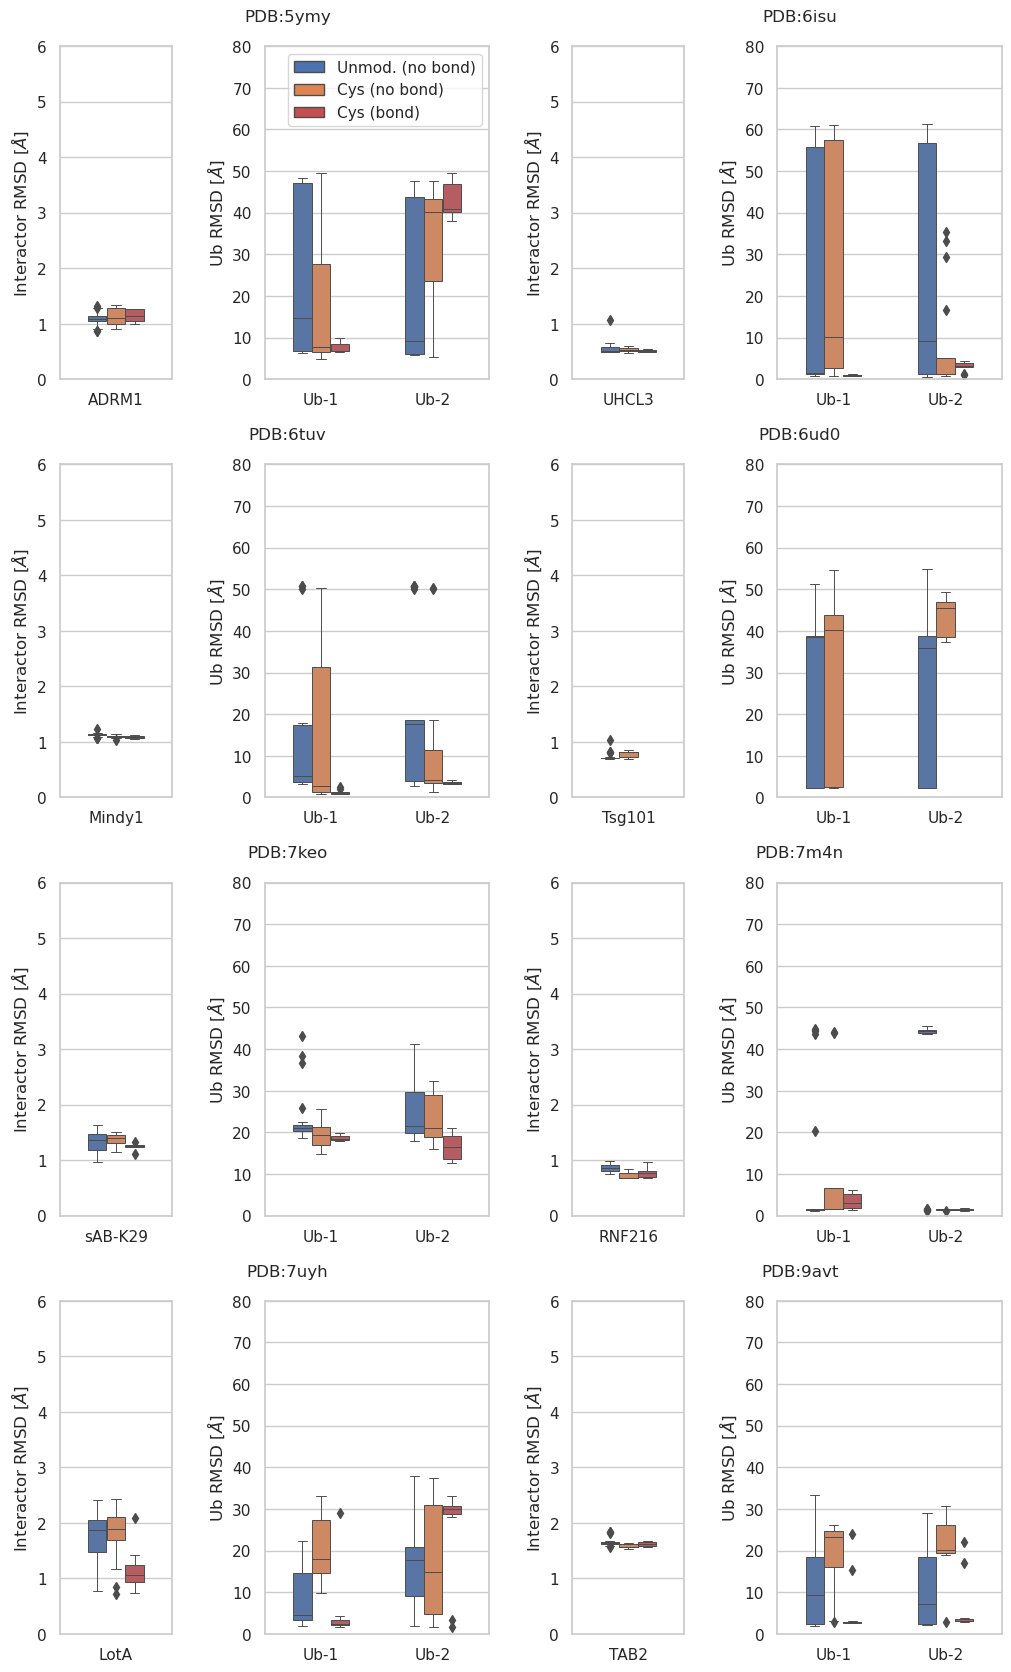

In [16]:
# use to set style of background of plot
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")

# Get the default color palette
colors = seaborn.color_palette()
colors = [i for index, i in enumerate(colors) if index not in [2]]  #Slightly more color-blind friendly

pdb_names = '5ymy','6isu','6tuv','6ud0','7keo','7m4n','7uyh','9avt'
protein_names = 'ADRM1', 'UHCL3', 'Mindy1', 'Tsg101', 'sAB-K29', 'RNF216', 'LotA', 'TAB2'

fig = plt.figure(layout="constrained", figsize=(10,20))
gs = GridSpec(5, 6, figure=fig, wspace=0.2, hspace=0.05)

cnt = 0

for pdb, protein in zip(pdb_names, protein_names):

    # Get column and row from cnt
    row = int(cnt/2)
    col = (cnt % 2) * 3
    
    ax1 = fig.add_subplot(gs[row, col])
    ax2 = fig.add_subplot(gs[row, col+1:col+3])
    ax2.set_title(f"PDB:{pdb}", x=0.1, y=1.05)

    seaborn.boxplot(x="PDB", y="RMSD", hue="bond", hue_order=["Unmod. (no bond)", "Cys (no bond)", "Cys (bond)"], data=target_rmsd_df[target_rmsd_df['PDB'] == pdb], ax=ax1, width=0.5, linewidth=0.7, palette=colors)
    ax1.set_ylabel(r'Interactor RMSD [$\AA$]')
    ax1.set_xticklabels([protein,])
    ax1.set_ylim([0,6]) 
    ax1.set_xlabel(None)
    legend = ax1.legend()
    legend.remove()
    
    

    data = monoub_rmsd_df[monoub_rmsd_df['PDB'] == pdb]
    seaborn.boxplot(x="proximal", y="RMSD", hue="bond", hue_order=["Unmod. (no bond)", "Cys (no bond)", "Cys (bond)"], data=data, ax=ax2, width=0.5, linewidth=0.7, palette=colors)
    ax2.set_ylabel(r'Ub RMSD [$\AA$]')
    ax2.set_xticklabels([r"Ub-1", r"Ub-2"])
    if cnt==0:
        ax2.legend(title=None)
        leg = ax2.get_legend()
        leg.legendHandles[0].set_facecolor(colors[0])
        leg.legendHandles[1].set_facecolor(colors[1])
        leg.legendHandles[2].set_facecolor(colors[2])
        leg.legendHandles[0].set_linewidth(1)
        leg.legendHandles[1].set_linewidth(1)
        leg.legendHandles[2].set_linewidth(1)
    else:
        legend = ax2.legend()
        legend.remove()
        
    ax2.set_xlabel(None)
    ax2.set_ylim([0,80])
    
    cnt += 1

plt.savefig(f"AF2.3-si-panel.svg", bbox_inches=0, transparent=True)
plt.savefig(f"AF2.3-si-panel.png", bbox_inches=0, transparent=False)
plt.show()

In [17]:
# AlphaFold scores dataframe

af_vs_rmsd_df=pd.DataFrame(diub_rmsd_df)
af_vs_rmsd_df["iptm+ptm"]=af_scores_df["iptm+ptm"]
print(diub_rmsd_df)
print(af_scores_df)
print(af_vs_rmsd_df)

      PDB       RMSD              bond  iptm+ptm
0    5ymy  11.256536  Unmod. (no bond)  0.327129
1    5ymy  30.556098  Unmod. (no bond)  0.287506
2    5ymy  30.757627  Unmod. (no bond)  0.298720
3    5ymy  31.306215  Unmod. (no bond)  0.312017
4    5ymy  12.243531  Unmod. (no bond)  0.346001
..    ...        ...               ...       ...
395  9avt  21.841350     Cys (no bond)  0.418547
396  9avt   2.908954        Cys (bond)  0.783781
397  9avt   2.872109        Cys (bond)  0.827010
398  9avt   3.342521        Cys (bond)  0.748368
399  9avt  22.732340     Cys (no bond)  0.211711

[400 rows x 4 columns]
      PDB  iptm+ptm              bond
0    5ymy  0.327129  Unmod. (no bond)
1    5ymy  0.287506  Unmod. (no bond)
2    5ymy  0.298720  Unmod. (no bond)
3    5ymy  0.312017  Unmod. (no bond)
4    5ymy  0.346001  Unmod. (no bond)
..    ...       ...               ...
395  9avt  0.418547     Cys (no bond)
396  9avt  0.783781        Cys (bond)
397  9avt  0.827010        Cys (bond)
398  9av

/tmp/ipykernel_1284655/1393039018.py:15: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  ax = seaborn.scatterplot(x="iptm+ptm", y="RMSD", hue="bond", hue_order=["Unmod. (no bond)", "Cys (no bond)", "Cys (bond)"], data=af_vs_rmsd_df, palette=colors, alpha=0.8)
/tmp/ipykernel_1284655/1393039018.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_facecolor(colors[0])
/tmp/ipykernel_1284655/1393039018.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_facecolor(colors[1])
/tmp/ipykernel_1284655/1393039018.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use le

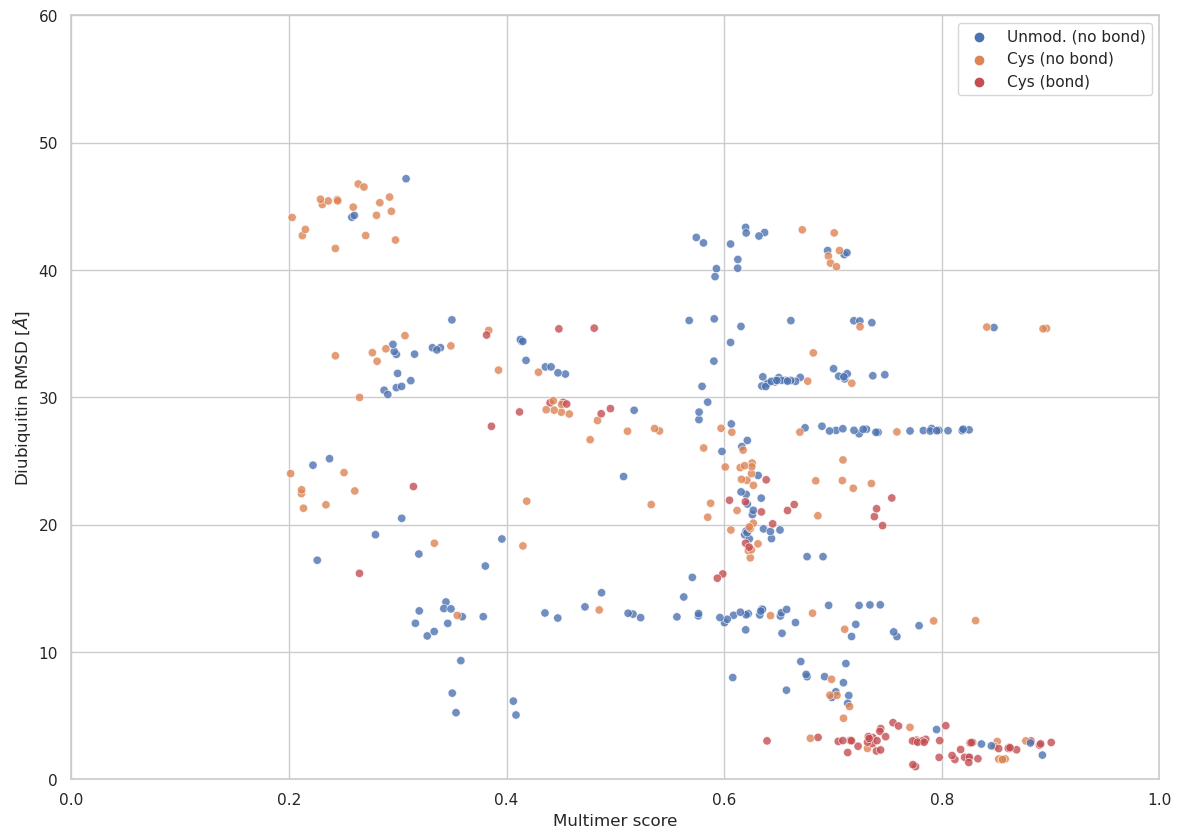

In [18]:
# AlphaFold scores

plt.rcParams['svg.fonttype'] = 'none'
# Get the default color palette
colors = seaborn.color_palette()
colors = [i for index, i in enumerate(colors) if index not in [2]]  #Slightly more color-blind friendly

fig = plt.figure(layout="constrained")
 
# use to set style of background of plot
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")


ax = seaborn.scatterplot(x="iptm+ptm", y="RMSD", hue="bond", hue_order=["Unmod. (no bond)", "Cys (no bond)", "Cys (bond)"], data=af_vs_rmsd_df, palette=colors, alpha=0.8)
ax.set_ylabel(r'Diubiquitin RMSD [$\AA$]')
ax.set_xlabel(r'Multimer score')
ax.set_ylim([0,60])
ax.set_xlim([0,1])
ax.legend(title=None)
leg = ax.get_legend()
leg.legendHandles[0].set_facecolor(colors[0])
leg.legendHandles[1].set_facecolor(colors[1])
leg.legendHandles[2].set_facecolor(colors[2])
leg.legendHandles[0].set_linewidth(1)
leg.legendHandles[1].set_linewidth(1)
leg.legendHandles[2].set_linewidth(1)

plt.savefig("AF2.3-diub-rmsd_vs_af.svg", bbox_inches=0, transparent=True)
plt.savefig("AF2.3-diub-rmsd_vs_af.png", bbox_inches=0, transparent=False)
plt.show()